In [1]:
from sys import path

path.append("../")

from gc import collect as garbage_collect

from joblib import Parallel, delayed
from numpy import ndarray, stack
from pandas import DataFrame, Series, option_context as pandas_option_context
from tqdm.auto import tqdm
from lazypredict.Supervised import LazyClassifier

from src.feature_extraction.eda import get_eda_features
from src.utils.experiment_info import ExperimentInfo
from src.utils.io import load_processed_data, filter_sleep_nights
from src.utils.misc import get_all_users
from src.utils.plots import (
    make_biometrics_plots_together_matplotlib,
    plot_binary_labels,
)
from src.utils.segmentation import segment
from src.utils.misc import get_labels_counts
from src.ml import resampling, local_resampling
from src.ml.cv import run_cross_validation_prediction
from src.ml.loso import run_same_side_classifications, run_different_classifications

# Intro

This notebook is intended to provide data exploration for all datasets concerning this Lateralization study. As the moment, the datasets impemented are:
* USILaughs
* MWC2022 study

I split the same notebook into 2, since I was having problems w/ remote working, due too large filesizes.

# Data Preparation

## Sleep Info

For the moment, I shall consider the self-reports for the sleep data.

In [3]:
path_to_experiment_info: str = '../data.nosync/mwc2022/all_experimento_info.csv'
experiment_info = ExperimentInfo(path=path_to_experiment_info, mode=2)
experiment_info.filter_correct_times(inplace=True)

## Physiological Data

In [4]:
eda_data_base_path: str = "../data.nosync/mwc2022/filtered/*/EDA/*.parquet"

eda_data = load_processed_data(path=eda_data_base_path, file_format="parquet")
garbage_collect()

Loading data:   0%|          | 0/19 [00:00<?, ?it/s]

489

In [4]:
eda_data = filter_sleep_nights(data=eda_data, experiment_info=experiment_info.to_df())

flitering user progress:   0%|          | 0/8 [00:00<?, ?it/s]

Removed 9 sessions


In [5]:
users = get_all_users(eda_data)
output_folder: str = "../visualizations/"
for user in tqdm(sorted(users), desc="Plotting user data", colour="red"):
    
    sessions_all_left = sorted(eda_data["left"][user].index.get_level_values(0).unique())
    sessions_all_right = sorted(eda_data["right"][user].index.get_level_values(0).unique())
    sessions_all = sorted(set(sessions_all_left) & set(sessions_all_right))
    
    for session in sessions_all:
        make_biometrics_plots_together_matplotlib(
            data={"EDA": eda_data},
            user_id=user,
            session_id=session,
            dataset="mwc2022",
            experiment_info=experiment_info.to_df(),
            eda_type="mixed-EDA",
            output_folder=output_folder
        )


Plotting user data:   0%|          | 0/8 [00:00<?, ?it/s]

In [5]:
users_in_left_side = set(eda_data['left'].keys())
users_in_right_side = set(eda_data['right'].keys())
print(f"Number of users with both left and right hand data: {len(users_in_left_side & users_in_right_side)}")

Number of users with both left and right hand data: 8


## Segmentation

In [6]:
segment_size_in_mins = 10
segment_size_in_secs = segment_size_in_mins * 60
eda_sample_rate = 4
segment_size_in_sampling_rate: int = segment_size_in_secs * eda_sample_rate

In [7]:
(
    values_left,
    values_right,
    labels_left,
    labels_right,
    groups_left,
    groups_right,
) = segment(
    data=eda_data,
    experiment_info_as_dict=experiment_info.to_dict(),
    segment_size_in_sampling_rate=segment_size_in_sampling_rate,
    segment_size_in_secs=segment_size_in_secs,
    data_sample_rate=eda_sample_rate,
    mode=experiment_info.get_mode(),
)


User progress:   0%|          | 0/8 [00:00<?, ?it/s]

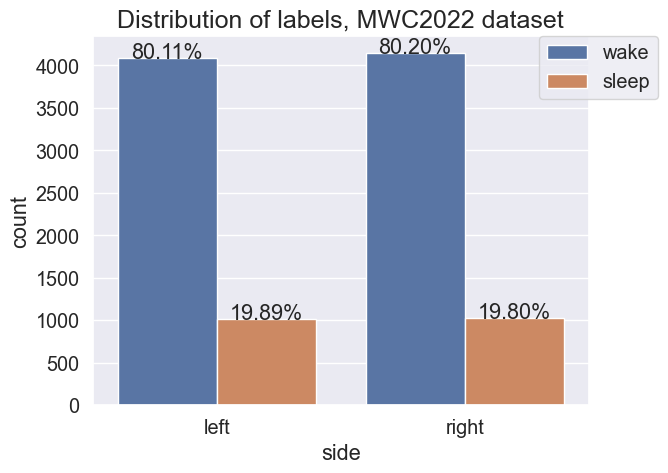

In [8]:
counts = get_labels_counts(labels_left, labels_right, ['sleep', 'wake'])

plot_binary_labels(
    counts=counts,
    title="Distribution of labels, MWC2022 dataset",
    dataset_name="mwc2022",
    output_folder="../visualizations/"
)


The distribution is almost balanced: as such, re-balancing should not be a large problem.

## Feature Extraction

In [9]:
features_left = Parallel(n_jobs=-1)(
    delayed(get_eda_features)(value) for value in (values_left)
)
features_right = Parallel(n_jobs=-1)(
    delayed(get_eda_features)(value) for value in (values_right)
)

features_left: ndarray = stack(features_left)
features_right: ndarray = stack(features_right)

labels_left: ndarray = stack(labels_left)
labels_right: ndarray = stack(labels_right)

groups_left: ndarray = stack(groups_left)
groups_right: ndarray = stack(groups_right)


/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/neurokit2/eda/eda_peaks.py:130: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])
/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/neurokit2/eda/eda_peaks.py:130: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])
Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/neurokit2/eda/eda_peaks.py:130: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(inf

In [10]:
print(f"{features_left.shape=}")
print(f"{labels_left.shape=}")
print(f"{groups_left.shape=}")

features_left.shape=(5103, 11)
labels_left.shape=(5103,)
groups_left.shape=(5103,)


# Machine Learning

## 5-fold CV (one seed)

In [11]:
model_selected: str = "RandomForestClassifier"
metrics_selected: str = "Accuracy"

#### LX v LX

In [12]:
averaged_results_cv_lxlx, all_results_cv_lxlx = run_cross_validation_prediction(
    x=features_left,
    y=labels_left,
    groups=groups_left,
    generator_seeds=[42, 666],
    n_seeds_to_test_classifiers=1,
    n_seeds_to_test_folds=1,
)


100%|██████████| 29/29 [00:01<00:00, 18.93it/s]


In [13]:
with pandas_option_context('display.float_format', '{:0.4f}'.format):
    display(averaged_results_cv_lxlx)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
NuSVC                           0.7532            0.7532  0.7532   0.7528   
LogisticRegression              0.7522            0.7522  0.7522   0.7506   
SVC                             0.7507            0.7507  0.7507   0.7500   
RandomForestClassifier          0.7507            0.7507  0.7507   0.7506   
CalibratedClassifierCV          0.7502            0.7502  0.7502   0.7491   
LGBMClassifier                  0.7498            0.7498  0.7498   0.7496   
XGBClassifier                   0.7473            0.7473  0.7473   0.7471   
ExtraTreesClassifier            0.7468            0.7468  0.7468   0.7467   
LinearSVC                       0.7458            0.7458  0.7458   0.7435   
BaggingClassifier               0.7409            0.7409  0.7409   0.7406   
KNeighborsClassifier            0.7389            0.7389  0.7389   0.7387   
RidgeClassifierCV               0.7379            0.7379  0.7379   0.7349   
RidgeClassifier                 0.7369            0.7369  0.7369   0.7339   
AdaBoostClassifier              0.7369            0.7369  0.7369   0.7369   
LinearDiscriminantAnalysis      0.7369            0.7369  0.7369   0.7339   
SGDClassifier                   0.7246            0.7246  0.7246   0.7211   
BernoulliNB                     0.7025            0.7025  0.7025   0.6995   
LabelSpreading                  0.6975            0.6975  0.6975   0.6959   
LabelPropagation                0.6966            0.6966  0.6966   0.6950   
NearestCentroid                 0.6951            0.6951  0.6951   0.6850   
DecisionTreeClassifier          0.6877            0.6877  0.6877   0.6875   
QuadraticDiscriminantAnalysis   0.6729            0.6729  0.6729   0.6661   
ExtraTreeClassifier             0.6665            0.6665  0.6665   0.6660   
GaussianNB                      0.6650            0.6650  0.6650   0.6468   
Perceptron                      0.6571            0.6571  0.6571   0.6389   
PassiveAggressiveClassifier     0.6138            0.6138  0.6138   0.5933   
DummyClassifier                 0.5000            0.5000  0.5000   0.3333   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
NuSVC                             0.0706         0.0121            0.0121   
LogisticRegression                0.0085         0.0105            0.0105   
SVC                               0.0578         0.0118            0.0118   
RandomForestClassifier            0.2475         0.0098            0.0098   
CalibratedClassifierCV            0.2759         0.0084            0.0084   
LGBMClassifier                    0.0614         0.0097            0.0097   
XGBClassifier                     0.1965         0.0072            0.0072   
ExtraTreesClassifier              0.1292         0.0054            0.0054   
LinearSVC                         0.0711         0.0116            0.0116   
BaggingClassifier                 0.0730         0.0075            0.0075   
KNeighborsClassifier              0.0107         0.0111            0.0111   
RidgeClassifierCV                 0.0049         0.0099            0.0099   
RidgeClassifier                   0.0054         0.0105            0.0105   
AdaBoostClassifier                0.1037         0.0164            0.0164   
LinearDiscriminantAnalysis        0.0082         0.0105            0.0105   
SGDClassifier                     0.0072         0.0115            0.0115   
BernoulliNB                       0.0042         0.0064            0.0064   
LabelSpreading                    0.0602         0.0074            0.0074   
LabelPropagation                  0.0321         0.0087            0.0087   
NearestCentroid           

#### RX vs RX

In [14]:
averaged_results_cv_rxrx, all_results_cv_rxrx = run_cross_validation_prediction(
    x=features_right,
    y=labels_right,
    groups=groups_right,
    generator_seeds=[42, 666],
    n_seeds_to_test_classifiers=1,
    n_seeds_to_test_folds=1,
)

100%|██████████| 29/29 [00:01<00:00, 18.43it/s]


In [15]:
with pandas_option_context('display.float_format', '{:0.4f}'.format):
    display(averaged_results_cv_rxrx)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
LGBMClassifier                  0.7429            0.7429  0.7429   0.7428   
RandomForestClassifier          0.7366            0.7365  0.7365   0.7365   
XGBClassifier                   0.7321            0.7321  0.7321   0.7320   
ExtraTreesClassifier            0.7238            0.7238  0.7238   0.7235   
AdaBoostClassifier              0.7219            0.7219  0.7219   0.7215   
BaggingClassifier               0.7111            0.7111  0.7111   0.7105   
SVC                             0.7062            0.7062  0.7062   0.7024   
NuSVC                           0.7062            0.7063  0.7063   0.7057   
LogisticRegression              0.7043            0.7043  0.7043   0.6987   
KNeighborsClassifier            0.7033            0.7033  0.7033   0.7031   
CalibratedClassifierCV          0.7009            0.7009  0.7009   0.6952   
LinearSVC                       0.6950            0.6950  0.6950   0.6873   
LinearDiscriminantAnalysis      0.6901            0.6901  0.6901   0.6808   
RidgeClassifier                 0.6896            0.6896  0.6896   0.6802   
LabelPropagation                0.6882            0.6882  0.6882   0.6852   
RidgeClassifierCV               0.6877            0.6877  0.6877   0.6778   
LabelSpreading                  0.6862            0.6863  0.6863   0.6833   
DecisionTreeClassifier          0.6491            0.6491  0.6491   0.6489   
PassiveAggressiveClassifier     0.6427            0.6427  0.6427   0.6303   
SGDClassifier                   0.6373            0.6373  0.6373   0.6199   
BernoulliNB                     0.6359            0.6359  0.6359   0.6278   
ExtraTreeClassifier             0.6334            0.6334  0.6334   0.6327   
GaussianNB                      0.6285            0.6285  0.6285   0.6016   
NearestCentroid                 0.6187            0.6187  0.6187   0.5993   
QuadraticDiscriminantAnalysis   0.5910            0.5909  0.5909   0.5608   
Perceptron                      0.5807            0.5804  0.5804   0.5549   
DummyClassifier                 0.4990            0.5000  0.5000   0.3322   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
LGBMClassifier                    0.0610         0.0121            0.0121   
RandomForestClassifier            0.2541         0.0082            0.0082   
XGBClassifier                     0.2012         0.0079            0.0079   
ExtraTreesClassifier              0.1352         0.0090            0.0090   
AdaBoostClassifier                0.1061         0.0085            0.0085   
BaggingClassifier                 0.0748         0.0112            0.0112   
SVC                               0.0659         0.0089            0.0089   
NuSVC                             0.0997         0.0123            0.0123   
LogisticRegression                0.0073         0.0163            0.0163   
KNeighborsClassifier              0.0105         0.0069            0.0069   
CalibratedClassifierCV            0.2850         0.0129            0.0129   
LinearSVC                         0.0733         0.0124            0.0124   
LinearDiscriminantAnalysis        0.0061         0.0131            0.0131   
RidgeClassifier                   0.0046         0.0131            0.0131   
LabelPropagation                  0.0312         0.0085            0.0085   
RidgeClassifierCV                 0.0048         0.0138            0.0138   
LabelSpreading                    0.0544         0.0082            0.0082   
DecisionTreeClassifier            0.0148         0.0056            0.0056   
PassiveAggressiveClassifier       0.0050         0.0098            0.0098   
SGDClassifier             

#### Visualizing differences

In [16]:
selected_results_rxrx = [
    (single_result.loc[model_selected, metrics_selected], "rx vs rx")
    for seed_res in all_results_cv_rxrx
    for single_result in seed_res
]

selected_results_lxlx = [
    (single_result.loc[model_selected, metrics_selected], "lx vs lx")
    for seed_res in all_results_cv_lxlx
    for single_result in seed_res
]

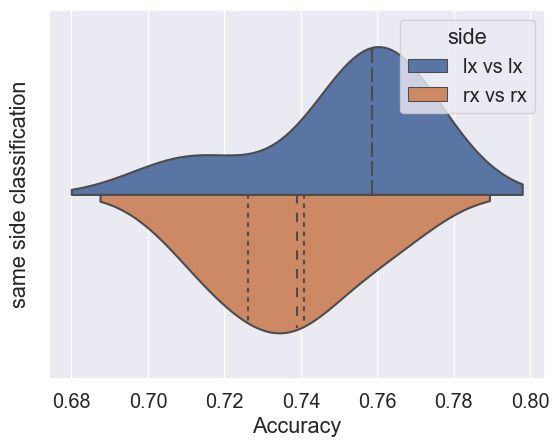

In [17]:
from seaborn import violinplot

extra_col_name: str = 'same side classification'
data_to_plot = DataFrame([*selected_results_lxlx, *selected_results_rxrx], columns=[metrics_selected, "side"])
data_to_plot[extra_col_name] = ""
ax = violinplot(data_to_plot, x=metrics_selected, y=extra_col_name, hue='side', split=True, inner='quartile')
# ax.set_ylim(0.5, 1.0)

#### LX vs RX

In [18]:
clf = LazyClassifier(predictions=True, random_state=42)

x_resampled_lx, y_resampled_lx, _ = local_resampling(features_left, labels_left, groups_left)
x_resampled_rx, y_resampled_rx, _ = local_resampling(features_right, labels_right, groups_right)
models_lxrx, _ = clf.fit(x_resampled_lx, x_resampled_rx, y_resampled_lx, y_resampled_rx)

100%|██████████| 29/29 [00:02<00:00, 10.87it/s]


In [19]:
models_lxrx.sort_values(by="Balanced Accuracy", ascending=False)

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NuSVC,0.71,0.71,0.71,0.70,0.20
SVC,0.70,0.70,0.70,0.70,0.18
CalibratedClassifierCV,0.70,0.70,0.70,0.70,0.33
LogisticRegression,0.70,0.70,0.70,0.69,0.01
AdaBoostClassifier,0.69,0.69,0.69,0.69,0.13
LinearSVC,0.69,0.69,0.69,0.68,0.11
SGDClassifier,0.68,0.68,0.68,0.68,0.01
RidgeClassifier,0.68,0.68,0.68,0.67,0.01
LinearDiscriminantAnalysis,0.68,0.68,0.68,0.67,0.01


#### RX vs LX

In [20]:
clf = LazyClassifier(predictions=True, random_state=42)

x_resampled_rx, y_resampled_rx, _ = local_resampling(features_right, labels_right, groups_right)
x_resampled_lx, y_resampled_lx, _ = local_resampling(features_left, labels_left, groups_left)
models_rxrx, predictions = clf.fit(x_resampled_rx, x_resampled_lx, y_resampled_rx, y_resampled_lx)

100%|██████████| 29/29 [00:02<00:00, 10.78it/s]


In [21]:
models_rxrx.sort_values(by="Balanced Accuracy", ascending=False)

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
SVC,0.74,0.74,0.74,0.74,0.19
SGDClassifier,0.74,0.74,0.74,0.74,0.01
LogisticRegression,0.73,0.73,0.73,0.73,0.01
RandomForestClassifier,0.73,0.73,0.73,0.73,0.37
CalibratedClassifierCV,0.73,0.73,0.73,0.73,0.34
LinearSVC,0.73,0.73,0.73,0.72,0.12
LGBMClassifier,0.72,0.72,0.72,0.72,0.41
LinearDiscriminantAnalysis,0.72,0.72,0.72,0.72,0.01
RidgeClassifier,0.72,0.72,0.72,0.72,0.01


## 5-fold CV - different seeds

### LX vs LX

The idea here is to run the same algorithms, but with different seeds. This allows to get an accuracy result which is averaged over different starting conditions. This should allow for the reported accuracy to be more robust to stochastic variations.

In [22]:
averaged_results_cv_multi_lxlx, all_results_cv_multi_lxlx = run_cross_validation_prediction(
    x=features_left,
    y=labels_left,
    groups=groups_left,
    generator_seeds=[42, 666],
    n_seeds_to_test_classifiers=10,
    n_seeds_to_test_folds=10,
)

Random states folds progress::   0%|          | 0/10 [00:00<?, ?it/s]

Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 19.60it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 19.54it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 19.63it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 19.73it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 19.94it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 19.61it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 19.50it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 19.47it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 19.49it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 19.97it/s]


In [23]:
with pandas_option_context('display.float_format', '{:0.4f}'.format):
    display(averaged_results_cv_multi_lxlx)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
RandomForestClassifier          0.7608            0.7608  0.7608   0.7606   
LGBMClassifier                  0.7582            0.7582  0.7582   0.7580   
XGBClassifier                   0.7561            0.7561  0.7561   0.7559   
ExtraTreesClassifier            0.7553            0.7553  0.7553   0.7552   
SVC                             0.7517            0.7517  0.7517   0.7510   
NuSVC                           0.7500            0.7500  0.7500   0.7496   
CalibratedClassifierCV          0.7491            0.7491  0.7491   0.7479   
LogisticRegression              0.7465            0.7465  0.7465   0.7448   
LinearSVC                       0.7428            0.7428  0.7428   0.7404   
BaggingClassifier               0.7370            0.7370  0.7370   0.7366   
LinearDiscriminantAnalysis      0.7369            0.7369  0.7369   0.7339   
RidgeClassifier                 0.7368            0.7368  0.7368   0.7338   
RidgeClassifierCV               0.7365            0.7365  0.7365   0.7333   
AdaBoostClassifier              0.7344            0.7344  0.7344   0.7342   
KNeighborsClassifier            0.7267            0.7267  0.7267   0.7265   
LabelSpreading                  0.7094            0.7094  0.7094   0.7080   
LabelPropagation                0.7079            0.7079  0.7079   0.7065   
SGDClassifier                   0.7073            0.7073  0.7073   0.7025   
BernoulliNB                     0.6986            0.6986  0.6986   0.6957   
NearestCentroid                 0.6942            0.6942  0.6942   0.6842   
DecisionTreeClassifier          0.6906            0.6906  0.6906   0.6904   
ExtraTreeClassifier             0.6694            0.6694  0.6694   0.6692   
GaussianNB                      0.6650            0.6650  0.6650   0.6470   
QuadraticDiscriminantAnalysis   0.6645            0.6645  0.6645   0.6496   
Perceptron                      0.6564            0.6564  0.6564   0.6456   
PassiveAggressiveClassifier     0.6395            0.6395  0.6395   0.6184   
DummyClassifier                 0.5000            0.5000  0.5000   0.3333   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
RandomForestClassifier            0.2474         0.0009            0.0009   
LGBMClassifier                    0.0600         0.0009            0.0009   
XGBClassifier                     0.1954         0.0008            0.0008   
ExtraTreesClassifier              0.1285         0.0009            0.0009   
SVC                               0.0576         0.0011            0.0011   
NuSVC                             0.0685         0.0010            0.0010   
CalibratedClassifierCV            0.2757         0.0010            0.0010   
LogisticRegression                0.0070         0.0011            0.0011   
LinearSVC                         0.0712         0.0011            0.0011   
BaggingClassifier                 0.0730         0.0009            0.0009   
LinearDiscriminantAnalysis        0.0055         0.0011            0.0011   
RidgeClassifier                   0.0047         0.0011            0.0011   
RidgeClassifierCV                 0.0049         0.0011            0.0011   
AdaBoostClassifier                0.1007         0.0011            0.0011   
KNeighborsClassifier              0.0100         0.0009            0.0009   
LabelSpreading                    0.0542         0.0011            0.0011   
LabelPropagation                  0.0305         0.0011            0.0011   
SGDClassifier                     0.0070         0.0024            0.0024   
BernoulliNB                       0.0043         0.0010            0.0010   
NearestCentroid           

### RX vs RX

In [24]:
averaged_results_cv_multi_rxrx, all_results_cv_multi_rxrx = run_cross_validation_prediction(
    x=features_right,
    y=labels_right,
    groups=groups_right,
    generator_seeds=[42, 666],
    n_seeds_to_test_classifiers=10,
    n_seeds_to_test_folds=10,
)

Random states folds progress::   0%|          | 0/10 [00:00<?, ?it/s]

Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 18.63it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 18.70it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 18.70it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 18.78it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 18.60it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 18.16it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 18.48it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 18.18it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 18.54it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 18.56it/s]


In [25]:
with pandas_option_context('display.float_format', '{:0.4f}'.format):
    display(averaged_results_cv_multi_rxrx)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
LGBMClassifier                  0.7316            0.7316  0.7316   0.7315   
RandomForestClassifier          0.7315            0.7315  0.7315   0.7313   
XGBClassifier                   0.7283            0.7283  0.7283   0.7282   
AdaBoostClassifier              0.7220            0.7220  0.7220   0.7216   
ExtraTreesClassifier            0.7201            0.7201  0.7201   0.7199   
BaggingClassifier               0.7125            0.7125  0.7125   0.7118   
SVC                             0.7054            0.7054  0.7054   0.7018   
NuSVC                           0.7049            0.7049  0.7049   0.7042   
LogisticRegression              0.7021            0.7021  0.7021   0.6965   
CalibratedClassifierCV          0.6979            0.6979  0.6979   0.6921   
KNeighborsClassifier            0.6955            0.6955  0.6955   0.6953   
LinearSVC                       0.6924            0.6925  0.6925   0.6845   
RidgeClassifier                 0.6860            0.6860  0.6860   0.6765   
LinearDiscriminantAnalysis      0.6860            0.6860  0.6860   0.6765   
RidgeClassifierCV               0.6849            0.6849  0.6849   0.6752   
LabelPropagation                0.6785            0.6785  0.6785   0.6759   
LabelSpreading                  0.6781            0.6781  0.6781   0.6754   
DecisionTreeClassifier          0.6579            0.6579  0.6579   0.6576   
SGDClassifier                   0.6559            0.6558  0.6558   0.6450   
ExtraTreeClassifier             0.6357            0.6357  0.6357   0.6354   
BernoulliNB                     0.6315            0.6315  0.6315   0.6229   
GaussianNB                      0.6298            0.6298  0.6298   0.6035   
QuadraticDiscriminantAnalysis   0.6295            0.6294  0.6294   0.6082   
NearestCentroid                 0.6218            0.6218  0.6218   0.6029   
Perceptron                      0.6056            0.6056  0.6056   0.5879   
PassiveAggressiveClassifier     0.5898            0.5898  0.5898   0.5607   
DummyClassifier                 0.4990            0.5000  0.5000   0.3322   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
LGBMClassifier                    0.0593         0.0010            0.0010   
RandomForestClassifier            0.2554         0.0010            0.0010   
XGBClassifier                     0.1978         0.0010            0.0010   
AdaBoostClassifier                0.1006         0.0009            0.0009   
ExtraTreesClassifier              0.1335         0.0010            0.0010   
BaggingClassifier                 0.0752         0.0010            0.0010   
SVC                               0.0661         0.0010            0.0010   
NuSVC                             0.0996         0.0010            0.0010   
LogisticRegression                0.0066         0.0011            0.0011   
CalibratedClassifierCV            0.2840         0.0010            0.0009   
KNeighborsClassifier              0.0104         0.0010            0.0010   
LinearSVC                         0.0731         0.0010            0.0010   
RidgeClassifier                   0.0048         0.0011            0.0011   
LinearDiscriminantAnalysis        0.0056         0.0011            0.0010   
RidgeClassifierCV                 0.0049         0.0011            0.0011   
LabelPropagation                  0.0327         0.0010            0.0010   
LabelSpreading                    0.0598         0.0010            0.0010   
DecisionTreeClassifier            0.0151         0.0009            0.0009   
SGDClassifier                     0.0073         0.0024            0.0024   
ExtraTreeClassifier       

#### Visualizing results

In [26]:
selected_results_rxrx = [
    (single_result.loc[model_selected, metrics_selected], "rx vs rx")
    for seed_res in all_results_cv_multi_rxrx
    for single_result in seed_res
]

selected_results_lxlx = [
    (single_result.loc[model_selected, metrics_selected], "lx vs lx")
    for seed_res in all_results_cv_multi_lxlx
    for single_result in seed_res
]

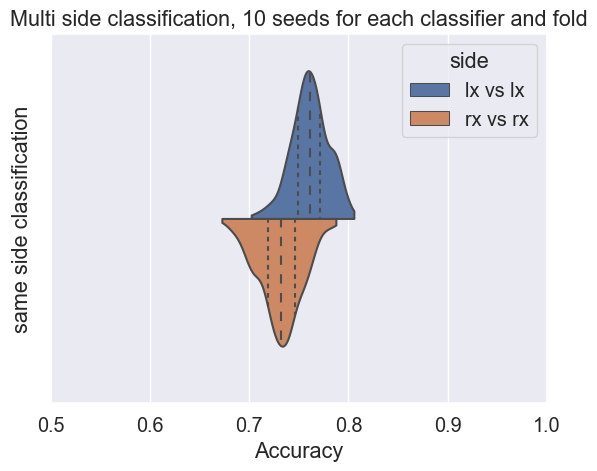

In [27]:
import matplotlib.pyplot as plt
from seaborn import violinplot

extra_col_name: str = 'same side classification'
data_to_plot = DataFrame([*selected_results_lxlx, *selected_results_rxrx], columns=[metrics_selected, "side"])
data_to_plot[extra_col_name] = ""
ax = violinplot(data_to_plot, x=metrics_selected, y=extra_col_name, hue='side', split=True, inner='quartile', cut=0)
plt.title("Multi side classification, 10 seeds for each classifier and fold")
ax.set_xlim(0.5, 1.0)
plt.show()

## LOSO

In [76]:
model_selected: str = "SVC"
metrics_selected: str = 'Accuracy'
n_seeds_to_test_classifiers: int = 30

### Test with different seeds (LX vs LX)

The idea here is to run the same algorithms, but with different seeds. This allows to get an accuracy result which is averaged over different starting conditions. This should allow for the reported accuracy to be more robust to stochastic variations.

In [29]:
averaged_results_loso_lxlx, all_results_loso_lxlx = run_same_side_classifications(
    features_left, labels_left, groups_left, n_seeds_to_test_classifiers=n_seeds_to_test_classifiers, n_jobs=-1
)


Random states classifiers progress::   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 16.56it/s]


In [30]:
with pandas_option_context('display.float_format', '{:0.4f}'.format):
    display(averaged_results_loso_lxlx)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
CalibratedClassifierCV          0.7590            0.7590  0.7590   0.7574   
LinearSVC                       0.7564            0.7564  0.7564   0.7533   
LogisticRegression              0.7559            0.7559  0.7559   0.7534   
RidgeClassifierCV               0.7537            0.7537  0.7537   0.7499   
RidgeClassifier                 0.7526            0.7526  0.7526   0.7488   
LinearDiscriminantAnalysis      0.7525            0.7525  0.7525   0.7487   
SVC                             0.7522            0.7522  0.7522   0.7510   
NuSVC                           0.7435            0.7435  0.7435   0.7417   
ExtraTreesClassifier            0.7359            0.7359  0.7359   0.7304   
RandomForestClassifier          0.7307            0.7307  0.7307   0.7237   
AdaBoostClassifier              0.7282            0.7282  0.7282   0.7235   
KNeighborsClassifier            0.7187            0.7187  0.7187   0.7133   
LGBMClassifier                  0.7172            0.7172  0.7172   0.7112   
SGDClassifier                   0.7165            0.7165  0.7165   0.7092   
XGBClassifier                   0.7157            0.7157  0.7157   0.7095   
BernoulliNB                     0.7068            0.7068  0.7068   0.7025   
BaggingClassifier               0.7054            0.7054  0.7054   0.7010   
LabelSpreading                  0.6959            0.6959  0.6959   0.6910   
LabelPropagation                0.6939            0.6939  0.6939   0.6886   
NearestCentroid                 0.6823            0.6823  0.6823   0.6696   
GaussianNB                      0.6608            0.6608  0.6608   0.6417   
QuadraticDiscriminantAnalysis   0.6604            0.6604  0.6604   0.6473   
Perceptron                      0.6592            0.6592  0.6592   0.6433   
PassiveAggressiveClassifier     0.6505            0.6505  0.6505   0.6302   
DecisionTreeClassifier          0.6488            0.6488  0.6488   0.6442   
ExtraTreeClassifier             0.6485            0.6485  0.6485   0.6454   
DummyClassifier                 0.5000            0.5000  0.5000   0.3333   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
CalibratedClassifierCV            0.3006         0.0082            0.0082   
LinearSVC                         0.0775         0.0082            0.0082   
LogisticRegression                0.0077         0.0085            0.0085   
RidgeClassifierCV                 0.0049         0.0080            0.0080   
RidgeClassifier                   0.0047         0.0083            0.0083   
LinearDiscriminantAnalysis        0.0056         0.0083            0.0083   
SVC                               0.0599         0.0093            0.0093   
NuSVC                             0.0784         0.0070            0.0070   
ExtraTreesClassifier              0.1400         0.0104            0.0104   
RandomForestClassifier            0.2684         0.0106            0.0106   
AdaBoostClassifier                0.1090         0.0095            0.0095   
KNeighborsClassifier              0.0088         0.0091            0.0091   
LGBMClassifier                    0.0595         0.0088            0.0088   
SGDClassifier                     0.0072         0.0090            0.0090   
XGBClassifier                     0.2099         0.0088            0.0088   
BernoulliNB                       0.0044         0.0089            0.0089   
BaggingClassifier                 0.0807         0.0090            0.0090   
LabelSpreading                    0.0574         0.0060            0.0060   
LabelPropagation                  0.0331         0.0063            0.0063   
NearestCentroid           

### Test with different seeds (RX vs RX)

In [31]:
averaged_results_loso_rxrx, all_results_loso_rxrx = run_same_side_classifications(
    features_right, labels_right, groups_right, n_seeds_to_test_classifiers=n_seeds_to_test_classifiers
)


Random states classifiers progress::   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 15.81it/s]


In [32]:
with pandas_option_context('display.float_format', '{:0.4f}'.format):
    display(averaged_results_loso_rxrx)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
SVC                             0.7210            0.7210  0.7210   0.7173   
LogisticRegression              0.7037            0.7037  0.7037   0.6949   
CalibratedClassifierCV          0.6991            0.6991  0.6991   0.6907   
AdaBoostClassifier              0.6973            0.6973  0.6973   0.6948   
LinearSVC                       0.6939            0.6939  0.6939   0.6833   
NuSVC                           0.6880            0.6880  0.6880   0.6861   
LinearDiscriminantAnalysis      0.6870            0.6870  0.6870   0.6755   
RidgeClassifier                 0.6863            0.6863  0.6863   0.6747   
RidgeClassifierCV               0.6842            0.6842  0.6842   0.6723   
RandomForestClassifier          0.6800            0.6800  0.6800   0.6771   
XGBClassifier                   0.6783            0.6783  0.6783   0.6748   
LGBMClassifier                  0.6723            0.6723  0.6723   0.6694   
ExtraTreesClassifier            0.6677            0.6677  0.6677   0.6647   
QuadraticDiscriminantAnalysis   0.6660            0.6660  0.6660   0.6508   
BaggingClassifier               0.6620            0.6620  0.6620   0.6586   
SGDClassifier                   0.6617            0.6617  0.6617   0.6473   
KNeighborsClassifier            0.6514            0.6514  0.6514   0.6486   
LabelPropagation                0.6481            0.6481  0.6481   0.6435   
LabelSpreading                  0.6440            0.6440  0.6440   0.6387   
GaussianNB                      0.6411            0.6411  0.6411   0.6134   
NearestCentroid                 0.6402            0.6402  0.6402   0.6187   
BernoulliNB                     0.6381            0.6381  0.6381   0.6263   
Perceptron                      0.6275            0.6275  0.6275   0.6075   
DecisionTreeClassifier          0.6060            0.6060  0.6060   0.6037   
PassiveAggressiveClassifier     0.6042            0.6042  0.6042   0.5702   
ExtraTreeClassifier             0.5954            0.5954  0.5954   0.5930   
DummyClassifier                 0.5000            0.5000  0.5000   0.3333   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
SVC                               0.0680         0.0077            0.0077   
LogisticRegression                0.0074         0.0054            0.0054   
CalibratedClassifierCV            0.3085         0.0052            0.0052   
AdaBoostClassifier                0.1094         0.0064            0.0064   
LinearSVC                         0.0796         0.0046            0.0046   
NuSVC                             0.1151         0.0052            0.0052   
LinearDiscriminantAnalysis        0.0058         0.0043            0.0043   
RidgeClassifier                   0.0049         0.0044            0.0044   
RidgeClassifierCV                 0.0050         0.0046            0.0046   
RandomForestClassifier            0.2764         0.0061            0.0061   
XGBClassifier                     0.2124         0.0064            0.0064   
LGBMClassifier                    0.0592         0.0070            0.0070   
ExtraTreesClassifier              0.1443         0.0063            0.0063   
QuadraticDiscriminantAnalysis     0.0043         0.0052            0.0052   
BaggingClassifier                 0.0825         0.0050            0.0050   
SGDClassifier                     0.0076         0.0067            0.0067   
KNeighborsClassifier              0.0090         0.0075            0.0075   
LabelPropagation                  0.0339         0.0054            0.0054   
LabelSpreading                    0.0594         0.0056            0.0056   
GaussianNB                

### Visualizing results (same side)

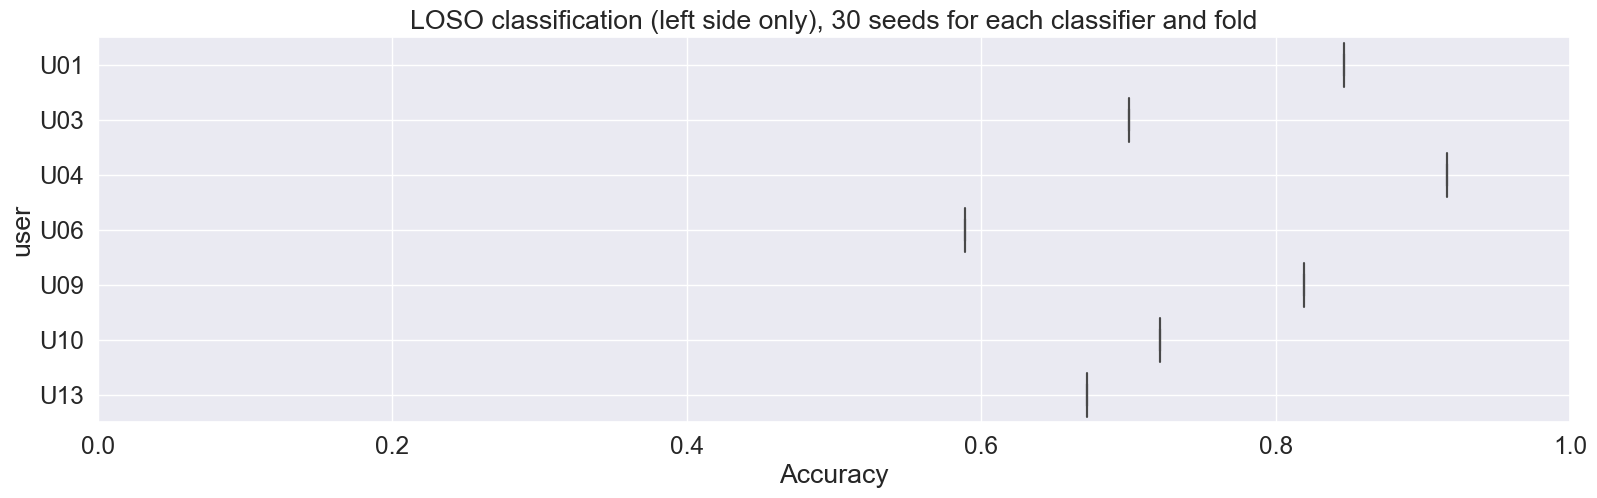

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns


selected_results_lxlx = [
    (single_result.loc[model_selected, metrics_selected], "lx vs lx", single_result.columns.name)
    for seed_res in all_results_loso_lxlx
    for single_result in seed_res
]

plt.figure(figsize=(19, 5))
sns.set_context("paper")
sns.set(font_scale=1.6)
data_to_plot = DataFrame([*selected_results_lxlx], columns=[metrics_selected, "side", "user"])
data_to_plot = data_to_plot.sort_values('user')
ax = sns.boxplot(data_to_plot, x=metrics_selected, y="user")
ax.xaxis.grid(True)
ax.yaxis.grid(True)
plt.title(f"LOSO classification (left side only), {n_seeds_to_test_classifiers} seeds for each classifier and fold")
ax.set_xlim(0., 1.0)
plt.show()


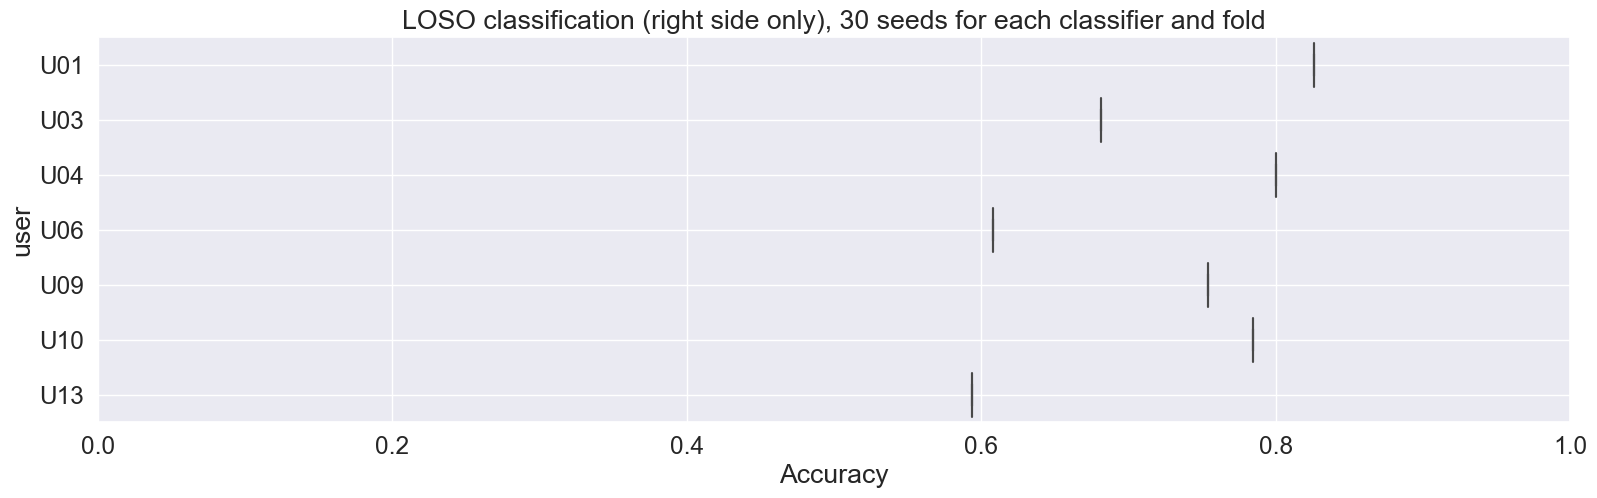

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns


selected_results_rxrx = [
    (single_result.loc[model_selected, metrics_selected], "lx vs lx", single_result.columns.name)
    for seed_res in all_results_loso_rxrx
    for single_result in seed_res
]

plt.figure(figsize=(19, 5))
sns.set_context("paper")
sns.set(font_scale=1.6)
data_to_plot = DataFrame([*selected_results_rxrx], columns=[metrics_selected, "side", "user"])
data_to_plot = data_to_plot.sort_values('user')
ax = sns.boxplot(data_to_plot, x=metrics_selected, y="user")
ax.xaxis.grid(True)
ax.yaxis.grid(True)
plt.title(f"LOSO classification (right side only), {n_seeds_to_test_classifiers} seeds for each classifier and fold")
ax.set_xlim(0., 1.0)
plt.show()


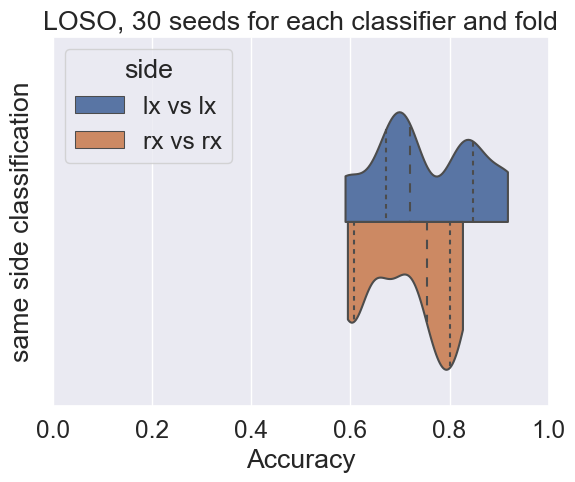

In [79]:
import matplotlib.pyplot as plt
from seaborn import violinplot

selected_results_rxrx = [
    (single_result.loc[model_selected, metrics_selected], "rx vs rx")
    for seed_res in all_results_loso_rxrx
    for single_result in seed_res
]

selected_results_lxlx = [
    (single_result.loc[model_selected, metrics_selected], "lx vs lx")
    for seed_res in all_results_loso_lxlx
    for single_result in seed_res
]

extra_col_name: str = 'same side classification'
data_to_plot = DataFrame([*selected_results_lxlx, *selected_results_rxrx], columns=[metrics_selected, "side"])
data_to_plot[extra_col_name] = ""
ax = violinplot(data_to_plot, x=metrics_selected, y=extra_col_name, hue='side', split=True, inner='quartile', cut=0)
plt.title(f"LOSO, {n_seeds_to_test_classifiers} seeds for each classifier and fold")
plt.xlim(0,1)
# ax.set_xlim(0.5, 1.0)
plt.show()

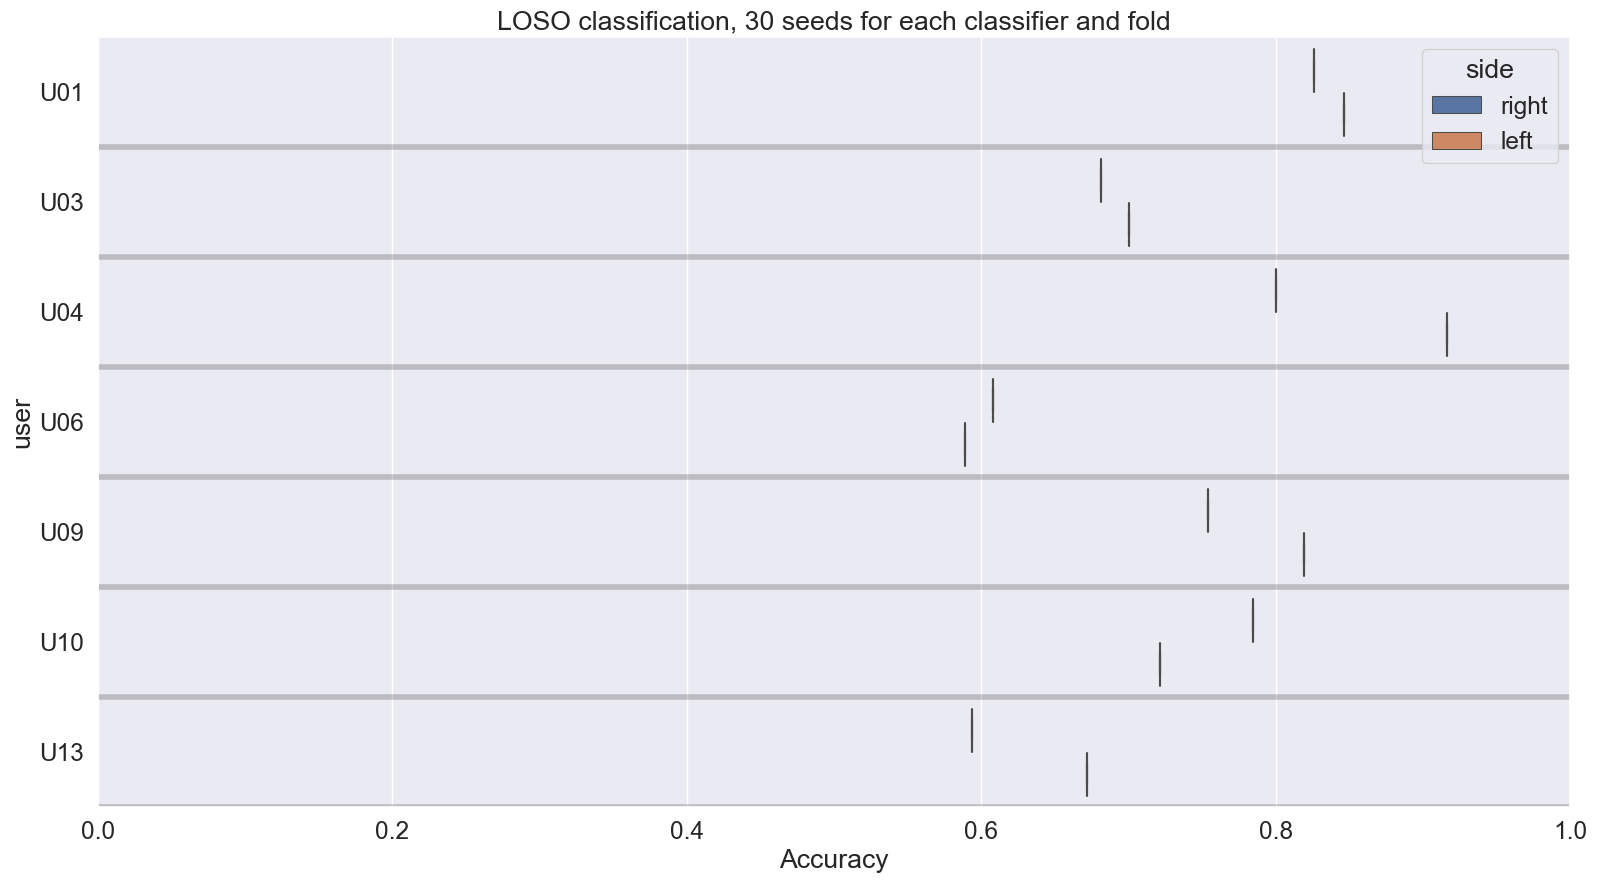

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator

selected_results_rxrx = [
    (single_result.loc[model_selected, metrics_selected], "right", single_result.columns.name)
    for seed_res in all_results_loso_rxrx
    for single_result in seed_res
]

selected_results_lxlx = [
    (single_result.loc[model_selected, metrics_selected], "left", single_result.columns.name)
    for seed_res in all_results_loso_lxlx
    for single_result in seed_res
]

plt.figure(figsize=(19, 10))
sns.set_context("paper")
sns.set(font_scale=1.6)
data_to_plot = DataFrame([*selected_results_rxrx, *selected_results_lxlx], columns=[metrics_selected, "side", "user"])
data_to_plot = data_to_plot.sort_values('user')
ax = sns.boxplot(data_to_plot, x=metrics_selected, y="user", hue='side')
ax.xaxis.grid(True)
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.grid(True, which='minor', linestyle='-', linewidth=4, color='black', alpha=0.2)
# ax.yaxis.grid(True, which='major', linestyle='-', linewidth=13, color='orange', alpha=0.3)
plt.title(f"LOSO classification, {n_seeds_to_test_classifiers} seeds for each classifier and fold")
ax.set_xlim(0., 1.0) 
plt.show()


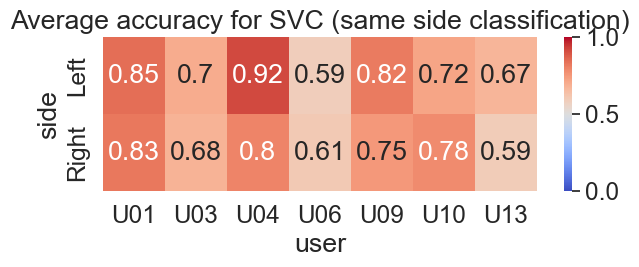

In [81]:
data_to_plot2 = data_to_plot.groupby(['user', 'side']).mean().unstack(level=[0]).T
data_to_plot2.index = data_to_plot2.index.droplevel(0)
data_to_plot2 = data_to_plot2.T
plt.figure(figsize=(len(data_to_plot2.columns), 2))
ax = sns.heatmap(data_to_plot2, 
            yticklabels=['Left', 'Right'],
            cmap='coolwarm', 
            annot=data_to_plot2.round(decimals=2),
            vmin=0, vmax=1,
            center=0.5,
            fmt="",)
plt.xticks(rotation=0, minor=True)
plt.title(f"Average accuracy for {model_selected} (same side classification)")
plt.show()

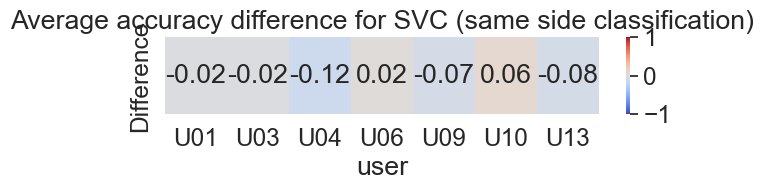

In [82]:
data_to_plot2 = data_to_plot.groupby(['user', 'side']).mean().unstack(level=[0]).T
data_to_plot2.index = data_to_plot2.index.droplevel(0)
data_to_plot2 = data_to_plot2.T
data_to_plot3 = data_to_plot2.iloc[1,:] - data_to_plot2.iloc[0,:]
data_to_plot3 = DataFrame(data_to_plot3, columns=['Difference']).T

plt.figure(figsize=(len(data_to_plot3.columns),1))
ax = sns.heatmap(data_to_plot3, 
            yticklabels=['Difference'],
            cmap='coolwarm', 
            annot=data_to_plot3.round(decimals=2).values,
            vmin=-1, vmax=1,
            center=0,
            fmt="",)
plt.xticks(rotation=0, minor=True)
plt.title(f"Average accuracy difference for {model_selected} (same side classification)")
plt.show()

Here is it noted that the distribution of labels across each individual is the same as the total, since the duration of the experiment was them same. It is also noted that a per-user undersampling is performed.

In [83]:
# from pandas import Series 

# selected_user: str = "s077"
# left_data_mask: ndarray = groups_left == selected_user
# current_labels_left = labels_left[left_data_mask]
# right_data_mask: ndarray = groups_right == selected_user
# current_labels_right = labels_right[right_data_mask]

# counts = {
#     "left": Series(current_labels_left).value_counts(),
#     "right": Series(current_labels_right).value_counts(),
# }
# counts = DataFrame(counts).unstack().reset_index()
# counts.columns = ["side", "label", "count"]
# counts["label"] = counts["label"].map({0: "relaxation", 1: "cognitive load"})
# plot_binary_labels(
#     counts=counts,
#     title=f"Distribution of labels, USILaughs dataset, user {selected_user}",
#     dataset_name=f"usilaughs_{selected_user}",
#     output_folder="../visualizations/"
# )


### Test with different seeds (LX vs RX)

In [47]:
averaged_results_loso_lxrx, all_results_loso_lxrx = run_different_classifications(
    x_train=features_left,
    x_test=features_right,
    y_train=labels_left,
    y_test=labels_right,
    folds_train=groups_left,
    folds_test=groups_right,
    n_seeds_to_test_classifiers=n_seeds_to_test_classifiers,
    n_jobs=-1,
)

Random states classifiers progress:   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 16.38it/s]


In [48]:
with pandas_option_context('display.float_format', '{:0.4f}'.format):
    display(averaged_results_loso_lxrx)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
CalibratedClassifierCV          0.7156            0.7156  0.7156   0.7127   
SVC                             0.7155            0.7155  0.7155   0.7128   
NuSVC                           0.7154            0.7154  0.7154   0.7127   
LogisticRegression              0.7107            0.7107  0.7107   0.7059   
LinearSVC                       0.7066            0.7066  0.7066   0.7006   
AdaBoostClassifier              0.6979            0.6979  0.6979   0.6962   
RidgeClassifierCV               0.6957            0.6957  0.6957   0.6872   
RidgeClassifier                 0.6944            0.6944  0.6944   0.6853   
LinearDiscriminantAnalysis      0.6944            0.6944  0.6944   0.6853   
XGBClassifier                   0.6937            0.6937  0.6937   0.6895   
RandomForestClassifier          0.6889            0.6889  0.6889   0.6821   
ExtraTreesClassifier            0.6889            0.6889  0.6889   0.6832   
KNeighborsClassifier            0.6845            0.6845  0.6845   0.6798   
LGBMClassifier                  0.6843            0.6843  0.6843   0.6805   
BaggingClassifier               0.6719            0.6719  0.6719   0.6696   
SGDClassifier                   0.6714            0.6714  0.6714   0.6608   
LabelSpreading                  0.6588            0.6588  0.6588   0.6548   
LabelPropagation                0.6578            0.6578  0.6578   0.6540   
BernoulliNB                     0.6483            0.6483  0.6483   0.6400   
QuadraticDiscriminantAnalysis   0.6439            0.6439  0.6439   0.6253   
NearestCentroid                 0.6408            0.6408  0.6408   0.6230   
GaussianNB                      0.6366            0.6366  0.6366   0.6130   
Perceptron                      0.6222            0.6222  0.6222   0.6035   
DecisionTreeClassifier          0.6165            0.6165  0.6165   0.6137   
PassiveAggressiveClassifier     0.6165            0.6165  0.6165   0.5905   
ExtraTreeClassifier             0.6079            0.6079  0.6079   0.6054   
DummyClassifier                 0.5000            0.5000  0.5000   0.3333   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
CalibratedClassifierCV            0.2992         0.0054            0.0054   
SVC                               0.0601         0.0059            0.0059   
NuSVC                             0.0784         0.0053            0.0053   
LogisticRegression                0.0077         0.0056            0.0056   
LinearSVC                         0.0775         0.0056            0.0056   
AdaBoostClassifier                0.1077         0.0060            0.0060   
RidgeClassifierCV                 0.0049         0.0048            0.0048   
RidgeClassifier                   0.0047         0.0049            0.0049   
LinearDiscriminantAnalysis        0.0058         0.0049            0.0049   
XGBClassifier                     0.2105         0.0081            0.0081   
RandomForestClassifier            0.2705         0.0081            0.0081   
ExtraTreesClassifier              0.1391         0.0081            0.0081   
KNeighborsClassifier              0.0088         0.0097            0.0097   
LGBMClassifier                    0.0598         0.0076            0.0076   
BaggingClassifier                 0.0804         0.0072            0.0072   
SGDClassifier                     0.0073         0.0073            0.0073   
LabelSpreading                    0.0584         0.0074            0.0074   
LabelPropagation                  0.0336         0.0074            0.0074   
BernoulliNB                       0.0044         0.0054            0.0054   
QuadraticDiscriminantAnaly

### Test with different seeds (RX vs LX)

In [49]:
averaged_results_loso_rxlx, all_results_loso_rxlx = run_different_classifications(
    x_train=features_right,
    x_test=features_left,
    y_train=labels_right,
    y_test=labels_left,
    folds_train=groups_right,
    folds_test=groups_left,
    n_jobs=6,
    n_seeds_to_test_classifiers=n_seeds_to_test_classifiers,
)

Random states classifiers progress:   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 19.58it/s]


In [50]:
with pandas_option_context('display.float_format', '{:0.4f}'.format):
    display(averaged_results_loso_rxlx)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
LogisticRegression              0.7522            0.7522  0.7522   0.7485   
CalibratedClassifierCV          0.7467            0.7467  0.7467   0.7433   
LinearSVC                       0.7445            0.7445  0.7445   0.7394   
SVC                             0.7420            0.7420  0.7420   0.7403   
RidgeClassifierCV               0.7359            0.7359  0.7359   0.7296   
RidgeClassifier                 0.7311            0.7311  0.7311   0.7248   
LinearDiscriminantAnalysis      0.7309            0.7309  0.7309   0.7245   
RandomForestClassifier          0.7276            0.7276  0.7276   0.7247   
AdaBoostClassifier              0.7267            0.7267  0.7267   0.7237   
LGBMClassifier                  0.7238            0.7238  0.7238   0.7201   
ExtraTreesClassifier            0.7238            0.7238  0.7238   0.7214   
XGBClassifier                   0.7121            0.7121  0.7121   0.7085   
NuSVC                           0.7119            0.7119  0.7119   0.7094   
SGDClassifier                   0.7097            0.7097  0.7097   0.7010   
KNeighborsClassifier            0.7029            0.7029  0.7029   0.7002   
BaggingClassifier               0.7014            0.7014  0.7014   0.6986   
BernoulliNB                     0.6912            0.6912  0.6912   0.6824   
NearestCentroid                 0.6879            0.6879  0.6879   0.6728   
QuadraticDiscriminantAnalysis   0.6855            0.6855  0.6855   0.6774   
LabelSpreading                  0.6851            0.6851  0.6851   0.6828   
LabelPropagation                0.6814            0.6814  0.6814   0.6788   
Perceptron                      0.6724            0.6724  0.6724   0.6580   
GaussianNB                      0.6528            0.6528  0.6528   0.6315   
PassiveAggressiveClassifier     0.6392            0.6392  0.6392   0.6134   
DecisionTreeClassifier          0.6228            0.6228  0.6228   0.6199   
ExtraTreeClassifier             0.6213            0.6213  0.6213   0.6186   
DummyClassifier                 0.5000            0.5000  0.5000   0.3333   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
LogisticRegression                0.0072         0.0091            0.0091   
CalibratedClassifierCV            0.3050         0.0094            0.0094   
LinearSVC                         0.0783         0.0082            0.0082   
SVC                               0.0673         0.0086            0.0086   
RidgeClassifierCV                 0.0049         0.0076            0.0076   
RidgeClassifier                   0.0048         0.0076            0.0076   
LinearDiscriminantAnalysis        0.0055         0.0076            0.0076   
RandomForestClassifier            0.2720         0.0087            0.0087   
AdaBoostClassifier                0.1072         0.0090            0.0090   
LGBMClassifier                    0.0587         0.0101            0.0101   
ExtraTreesClassifier              0.1403         0.0087            0.0087   
XGBClassifier                     0.2099         0.0088            0.0088   
NuSVC                             0.1131         0.0064            0.0064   
SGDClassifier                     0.0076         0.0084            0.0084   
KNeighborsClassifier              0.0086         0.0085            0.0085   
BaggingClassifier                 0.0817         0.0078            0.0078   
BernoulliNB                       0.0043         0.0075            0.0075   
NearestCentroid                   0.0058         0.0070            0.0070   
QuadraticDiscriminantAnalysis     0.0042         0.0075            0.0075   
LabelSpreading            

These results suggest that the test set is the one having the greater importance in the performance of "different sides classifier". However, it is unclear if this is due actual lateralization effect, or due to other factors in play, e.g., artefacts.

### Visualizing results (different side)

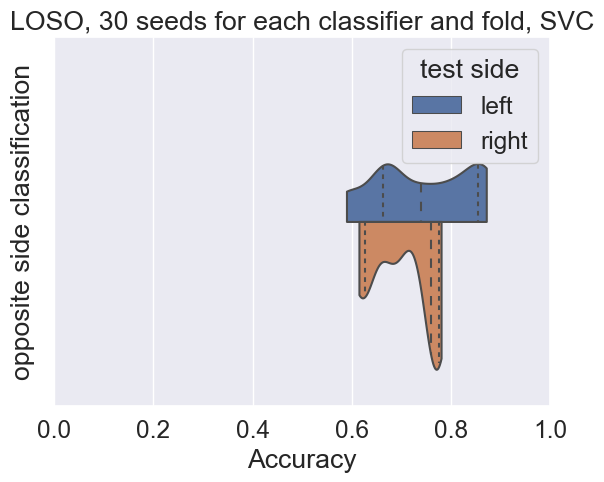

In [84]:
import matplotlib.pyplot as plt
from seaborn import violinplot

selected_results_lxrx = [
    (single_result.loc[model_selected, metrics_selected], "right")
    for seed_res in all_results_loso_lxrx
    for single_result in seed_res
]

selected_results_rxlx = [
    (single_result.loc[model_selected, metrics_selected], "left")
    for seed_res in all_results_loso_rxlx
    for single_result in seed_res
]

extra_col_name: str = 'opposite side classification'
data_to_plot = DataFrame([*selected_results_rxlx, *selected_results_lxrx], columns=[metrics_selected, "test side"])
data_to_plot[extra_col_name] = ""
ax = violinplot(data_to_plot, x=metrics_selected, y=extra_col_name, hue='test side', split=True, inner='quartile', cut=0)
plt.title(f"LOSO, {n_seeds_to_test_classifiers} seeds for each classifier and fold, {model_selected}")
ax.set_xlim(0., 1.0)
plt.show()

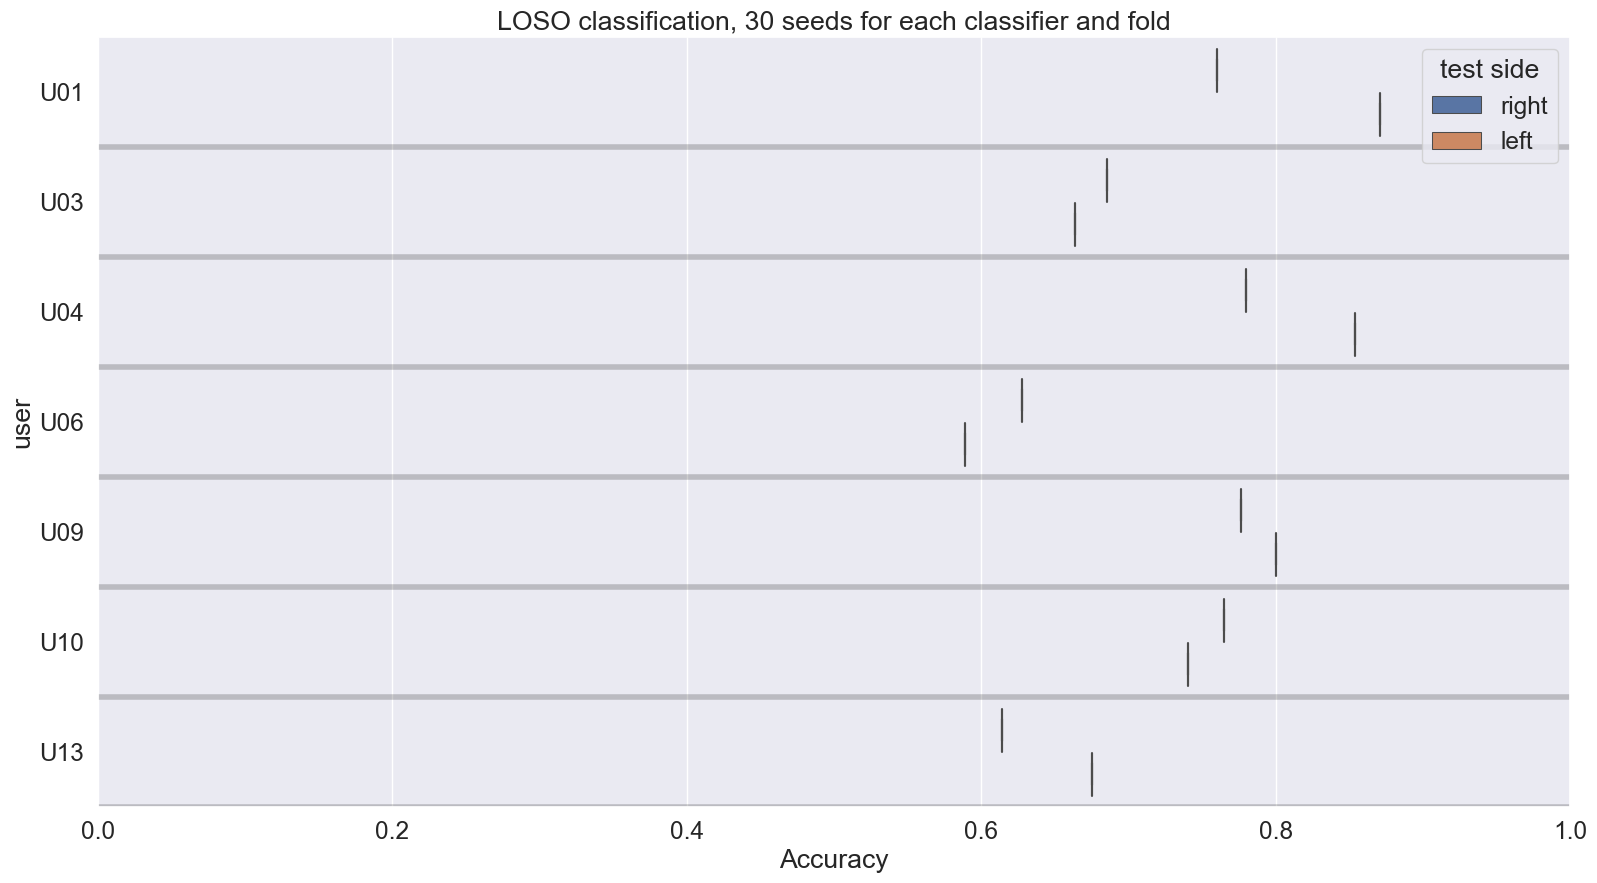

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator

selected_results_lxrx = [
    (single_result.loc[model_selected, metrics_selected], "right", single_result.columns.name)
    for seed_res in all_results_loso_lxrx
    for single_result in seed_res
]

selected_results_rxlx = [
    (single_result.loc[model_selected, metrics_selected], "left", single_result.columns.name)
    for seed_res in all_results_loso_rxlx
    for single_result in seed_res
]

plt.figure(figsize=(19, 10))
sns.set_context("paper")
sns.set(font_scale=1.6)
data_to_plot = DataFrame([*selected_results_lxrx, *selected_results_rxlx], columns=[metrics_selected, "test side", "user"])
data_to_plot = data_to_plot.sort_values('user')
ax = sns.boxplot(data_to_plot, x=metrics_selected, y="user", hue='test side')
ax.xaxis.grid(True)
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.grid(True, which='minor', linestyle='-', linewidth=4, color='black', alpha=0.2)
# ax.yaxis.grid(True, which='major', linestyle='-', linewidth=13, color='orange', alpha=0.3)
plt.title(f"LOSO classification, {n_seeds_to_test_classifiers} seeds for each classifier and fold")
ax.set_xlim(0., 1.0) 
plt.show()


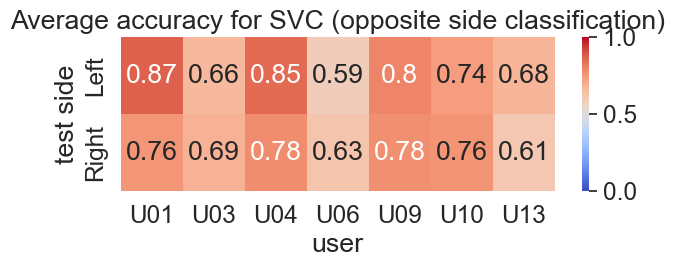

In [86]:
data_to_plot2 = data_to_plot.groupby(['user', 'test side']).mean().unstack(level=[0]).T
data_to_plot2.index = data_to_plot2.index.droplevel(0)
data_to_plot2 = data_to_plot2.T
plt.figure(figsize=(len(data_to_plot2.columns), 2))
ax = sns.heatmap(data_to_plot2, 
            yticklabels=['Left', 'Right'],
            cmap='coolwarm', 
            annot=data_to_plot2.round(decimals=2),
            vmin=0, vmax=1,
            center=0.5,
            fmt="",)
plt.xticks(rotation=0, minor=True)
plt.title(f"Average accuracy for {model_selected} (opposite side classification)")
plt.show()

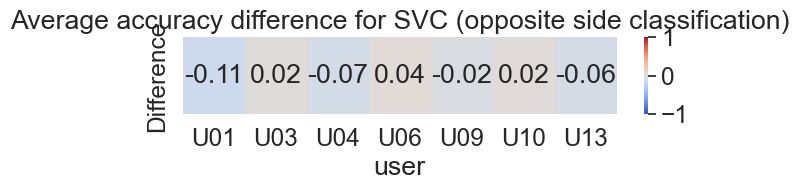

In [87]:
data_to_plot2 = data_to_plot.groupby(['user', 'test side']).mean().unstack(level=[0]).T
data_to_plot2.index = data_to_plot2.index.droplevel(0)
data_to_plot2 = data_to_plot2.T
data_to_plot3 = data_to_plot2.iloc[1,:] - data_to_plot2.iloc[0,:]
data_to_plot3 = DataFrame(data_to_plot3, columns=['Difference']).T

plt.figure(figsize=(len(data_to_plot3.columns),1))
ax = sns.heatmap(data_to_plot3, 
            yticklabels=['Difference'],
            cmap='coolwarm', 
            annot=data_to_plot3.round(decimals=2).values,
            vmin=-1, vmax=1,
            center=0,
            fmt="",)
plt.xticks(rotation=0, minor=True)
plt.title(f"Average accuracy difference for {model_selected} (opposite side classification)")
plt.show()

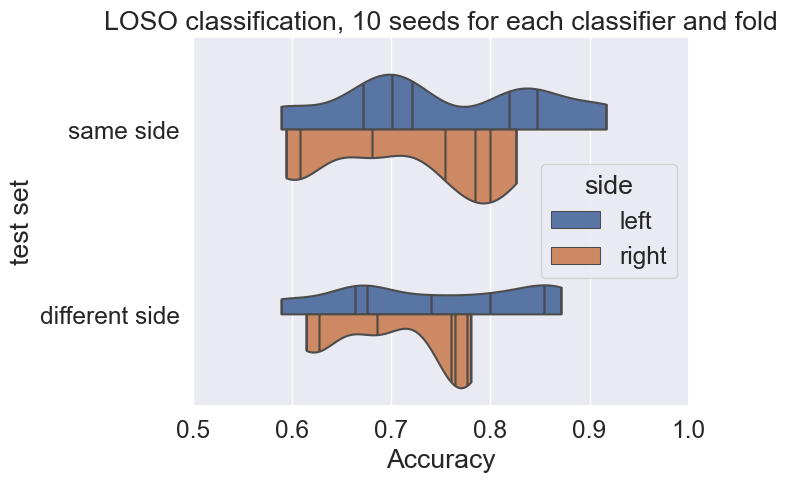

In [89]:
import matplotlib.pyplot as plt
from seaborn import violinplot

selected_results_rxrx = [
    (single_result.loc[model_selected, metrics_selected], "right", "same side")
    for seed_res in all_results_loso_rxrx
    for single_result in seed_res
]

selected_results_lxlx = [
    (single_result.loc[model_selected, metrics_selected], "left", "same side")
    for seed_res in all_results_loso_lxlx
    for single_result in seed_res
]

selected_results_lxrx = [
    (single_result.loc[model_selected, metrics_selected], "right", "different side")
    for seed_res in all_results_loso_lxrx
    for single_result in seed_res
]

selected_results_rxlx = [
    (single_result.loc[model_selected, metrics_selected], "left", "different side")
    for seed_res in all_results_loso_rxlx
    for single_result in seed_res
]

data_to_plot = DataFrame([*selected_results_lxlx, *selected_results_rxrx, *selected_results_lxrx, *selected_results_rxlx], columns=[metrics_selected, "side", "test set"])
ax = violinplot(data_to_plot, x=metrics_selected, y="test set", hue='side', split=True, inner='stick', cut=0)
plt.title("LOSO classification, 10 seeds for each classifier and fold")
ax.set_xlim(0.5, 1.0)
plt.show()